**TIP**: This training could take several hours depending on how many iterations you chose in the .cfg file. You will want to let this run as you sleep or go to work for the day, etc. However, Colab Cloud Service kicks you off it's VMs if you are idle for too long (30-90 mins).

To avoid this hold (CTRL + SHIFT + i) at the same time to open up the inspector view on your browser.

Paste the following code into your console window and hit Enter


```
function ClickConnect(){
console.log("Working");
document.querySelector("colab-toolbar-button#connect").click()
}
setInterval(ClickConnect,60000)
```



Looks like this, it will click the screen every 10 minutes so that you don't get kicked off for being idle! HACKS!


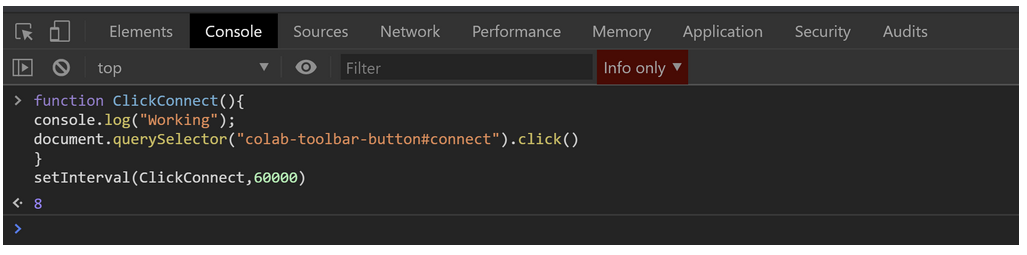

# Setups

GPU specs

In [1]:
!nvidia-smi

Sat Dec 21 01:57:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0              49W / 400W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

Enabling and testing the GPU

First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [3]:
!pip install imgaug
!pip install -U opencv-python # We need the most recent version of OpenCV.
!pip install tdqm
%tensorflow_version 2.x

  Preparing metadata (setup.py) ... done
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1320 sha256=19ade482bef55128f93236ea4db7c122d4ae3312a46e4e13e059abc9ac2f1a2a
  Stored in directory: /root/.cache/pip/wheels/37/31/b8/7b711038035720ba0df14376af06e5e76b9bd61759c861ad92
Successfully built tdqm
Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


Link to GDrive

In [4]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

/
Mounted at /content/gdrive
 backup				   tensorflow-yolov4
 caire				  'tensorflow-yolov4-tflite(old)'
 colab				   test1.JPG
'Colab Notebooks'		   test2.JPG
 colmap				   test3.JPG
 darknet			   test4.JPG
 data				   tinyml
 December_2020.gslides		   TripCommonControllerV1.gslides
 Document_classifier.gslides	   trt_infer.py
 DocumentScanner		  'TrtYOLODemo_screenshot_16.02.2021(2).png'
'DocumentScanner V3.gslides'	   TrtYOLODemo_screenshot_16.02.2021.png
 Drive				  'Untitled 2.ods'
 ExperimentingBestEncoder.ipynb   'Untitled presentation (1).gslides'
 FastCampus			  'Untitled presentation (2).gslides'
 Feb_2021.gslides		  'Untitled presentation (3).gslides'
 garage				  'Untitled presentation.gslides'
'IMG_0689 (1).MOV'		   utils.zip
 IMG_0689.MOV			   zb1
 IMG_0724.MOV			   ZB1_ocr.gslides
 IMG_0733.MOV			  '파일_000 (1).jpeg'
 IMG_0734.MOV			  '파일_000 (2).jpeg'
 IMG_0791.MOV			   파일_000.jpeg
 IMG_1333.MOV			  '파일_001 (1).jpeg'
 IMG_9239.MOV			   파일_001.jpeg
 IMG_924

Load original Dataset to core

In [5]:
%cd /content/
!cp /content/gdrive/MyDrive/caire/CodingImages.zip .

/content


In [6]:
!unzip ./CodingImages.zip -d /content/

Archive:  ./CodingImages.zip
   creating: /content/CodingImages/
  inflating: /content/CodingImages/img_2216.bmp  
  inflating: /content/CodingImages/img_3442.bmp  
  inflating: /content/CodingImages/img_2127.bmp  
  inflating: /content/CodingImages/img_2629.bmp  
  inflating: /content/CodingImages/img_1676.bmp  
  inflating: /content/CodingImages/img_1014.bmp  
  inflating: /content/CodingImages/img_1765.bmp  
  inflating: /content/CodingImages/img_3888.bmp  
  inflating: /content/CodingImages/img_50.bmp  
  inflating: /content/CodingImages/img_2380.bmp  
  inflating: /content/CodingImages/img_3306.bmp  
  inflating: /content/CodingImages/img_4035.bmp  
  inflating: /content/CodingImages/img_746.bmp  
  inflating: /content/CodingImages/img_3685.bmp  
  inflating: /content/CodingImages/img_182.bmp  
  inflating: /content/CodingImages/img_3678.bmp  
  inflating: /content/CodingImages/img_462.bmp  
  inflating: /content/CodingImages/img_4023.bmp  
  inflating: /content/CodingImages/img_4

Copy and paste csv files

In [7]:
!cp /content/gdrive/MyDrive/caire/trainingset.csv .
!cp /content/gdrive/MyDrive/caire/validationset.csv .

# Data preparation

In [8]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps


def load_images_from_folder(folder, filenames):
    images = []
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            if img is not None:
                img = ImageOps.fit(img, (224, 224))  # Resize image while maintaining aspect ratio
                new_img = Image.new("RGB", (224, 224), (255,255,255))
                new_img.paste(img, ((224 - img.size[0]) // 2, (224 - img.size[1]) // 2))
                new_img = np.array(new_img) / 255.0  # Normalize pixel values
                images.append(new_img)
    return np.array(images)

def load_labels_from_csv(file_path):
    df = pd.read_csv(file_path)

    training_data = df[df['is_training'] == 1]
    validation_data = df[df['is_training'] == 0]

    y_train, train_filenames = training_data['bmi'].values, training_data['name'].values
    y_val, val_filenames = validation_data['bmi'].values, validation_data['name'].values

    return y_train, train_filenames, y_val, val_filenames

def load_test_labels_from_csv(file_path):
    df = pd.read_csv(file_path)
    return df['bmi'].values, df['name'].values

image_folder = os.path.join(os.getcwd(), 'CodingImages')
dataset_csv = os.path.join(os.getcwd(), 'trainingset.csv')
testset_csv = os.path.join(os.getcwd(), 'validationset.csv')

y_train, train_filenames, y_val, val_filenames = load_labels_from_csv(dataset_csv)
x_train = load_images_from_folder(image_folder, train_filenames)
x_val = load_images_from_folder(image_folder, val_filenames)

print(f'Loaded {x_train.shape[0]} training images')
print(f'Loaded {y_train.shape[0]} training labels')
print(f'Loaded {x_val.shape[0]} validation images')
print(f'Loaded {y_val.shape[0]} validation labels')

y_test, test_filenames = load_test_labels_from_csv(testset_csv)
x_test = load_images_from_folder(image_folder, test_filenames)

print(f'Loaded {x_test.shape[0]} test images')
print(f'Loaded {y_test.shape[0]} test labels')

Loaded 2051 training images
Loaded 2051 training labels
Loaded 485 validation images
Loaded 485 validation labels
Loaded 634 test images
Loaded 634 test labels


# Compare model architectures


## Comparison of Model Architectures for BMI Prediction from Images





| Feature | VGG16 | VGG19 | ResNet50 | InceptionV3 |
|---|---|---|---|---|
| Input Size | (224, 224, 3) | (224, 224, 3) | (224, 224, 3) | (299, 299, 3) |
| Parameters | ~138 million | ~144 million | ~25 million | ~23 million |
| Depth | 16 layers | 19 layers | 50 layers | 48 layers |
| Architecture Type | Sequential | Sequential | Residual | Inception |
| Computational Cost | High | High | Moderate | Moderate |
| Feature Extraction | Strong | Strong | Strong | Strong |
| Overfitting Tendency | Prone | Prone | Less Prone | Less Prone |


Sources:

- **VGG16 and VGG19:**
    - Simonyan, Karen, and Andrew Zisserman. "Very deep convolutional networks for large-scale image recognition." arXiv preprint arXiv:1409.1556 (2014).
    - [https://keras.io/api/applications/vgg/#vgg16-function](https://keras.io/api/applications/vgg/#vgg16-function)
    - [https://keras.io/api/applications/vgg/#vgg19-function](https://keras.io/api/applications/vgg/#vgg19-function)
- **ResNet50:**
    - He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
    - [https://keras.io/api/applications/resnet/#resnet50-function](https://keras.io/api/applications/resnet/#resnet50-function)
- **InceptionV3:**
    - Szegedy, Christian, et al. "Rethinking the inception architecture for computer vision." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.
    - [https://keras.io/api/applications/inception/#inceptionv3-function](https://keras.io/api/applications/inception/#inceptionv3-function)

##VGG16

### Result

(10 epoch with 32 batch)
##### MAE result with Dense layer before Dropout

|  | Dense: 128 | Dense: 4096 |
|---|---|---|
| **Dropout: 0.25** | 5.25 | 5.22 |
| **Dropout: 0.5** | 5.25 | 5.00 |

##### MAE result with Dense layer after Dropout

|  | Dropout: 0.25 | Dropout: 0.5 |
|---|---|---|
| **Dense: 128** | 5.15 | 5.12 |
| **Dense: 4096** | **4.97** | 5.12 |

Placing 4096-unit dense layer on top of the dropout layer with a rate of 0.25, as the final layer in the network, resulted in the most favorable outcome.

### Code

In [9]:
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten and Dense
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import mean_absolute_error


def VGG16_training(dropout, dense_unit, dropout_first=True):
    # 1. Load the pre-trained VGG16 model (with ImageNet weights)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = Flatten()(x)
    if dropout_first:
        x = Dropout(dropout)(x)
        x = Dense(dense_unit, activation='relu')(x)
    else:
        x = Dense(dense_unit, activation='relu')(x)
        x = Dropout(dropout)(x)
    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    # Initialize variables for tracking best MAE
    best_mae = np.inf
    best_model_weights = None

    epochs = 10
    batch_size = 32

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train the model for one epoch
        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=1,  # Train one epoch at a time
            batch_size=batch_size,
            verbose=1
        )

        # Evaluate the model on validation data
        val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
       # print(f"Validation MAE: {val_mae:.4f}")

        # Save the model if MAE improves
        if val_mae < best_mae:
            best_mae = val_mae
            best_model_weights = model.get_weights()  # Save current best weights
            print(f"New best MAE: {best_mae:.4f}. Model weights saved.")

    # Load the best weights into the model
    model.set_weights(best_model_weights)

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    if dropout_first:
        print(f"dropout={dropout}, dense_unit={dense_unit}, Mean Absolute Error (MAE): {mae:.2f}")
    else:
        print(f"dense_unit={dense_unit}, dropout={dropout}, Mean Absolute Error (MAE): {mae:.2f}")

     # free memory
    del model
    gc.collect()


In [11]:
def run_training_sequence():
    training_parameters = [
        (0.5, 128, True),
        (0.25, 4096, True),
        (0.5, 4096, True),
        (0.25, 128, False),
        (0.5, 128, False),
        (0.25, 4096, False),
        (0.5, 4096, False)
    ]

    for dropout, dense_unit, dropout_first in training_parameters:
        VGG16_training(dropout, dense_unit, dropout_first)

run_training_sequence()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 262ms/step - loss: 326.0662 - mae: 14.1627 - val_loss: 95.4663 - val_mae: 7.0602
New best MAE: 7.0602. Model weights saved.
Epoch 2/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 154ms/step - loss: 69.2738 - mae: 6.4321 - val_loss: 82.5496 - val_mae: 6.7141
New best MAE: 6.7141. Model weights saved.
Epoch 3/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 155ms/step - loss: 60.6739 - mae: 5.9823 - val_loss: 80.5369 - val_mae: 6.3894
New best MAE: 6.3894. Model weights saved.
Epoch 4/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 156ms/step - loss: 56.6640 - mae: 5.7428 - val_loss: 87.9304 - val_mae: 6.5099
Epoch 5/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 52.7925 - mae: 5.5881 - val_loss: 71.2179 - val_mae: 6.0873
New best MAE: 6.0873. Model weights saved.
Epoch 6/10
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 160ms/step - loss: 47.8386 - mae: 5.4117 - val_loss: 70.0648 - val_mae: 5.9628
New best MAE: 5.9628. Model weights saved.
Epoch 

### Result with augmentation

In [30]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

flatten (Flatten)

fc1 (Dense)  4096

fc2 (Dense)  4096   
     
predictions (Dense)     

In [31]:
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten and Dense
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_mae',  # Metric to monitor for early stopping (validation MAE in this case)
    patience=5,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)



def VGG16_training(dropout=None, dense=None, total_epochs=30):
    # 1. Load the pre-trained VGG16 model (with ImageNet weights)
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = Flatten()(x)
    if dropout:
        x = Dropout(dropout)(x)
    x = Dense(4096, activation='relu')(x)
    if dense:
        x = Dropout(dropout)(x)
        x = Dense(dense, activation='relu')(x)
    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    batch_size = 64

    # Train the model for one epoch
    model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),  # augmentation
        epochs=total_epochs,
        validation_data=(x_val, y_val),
        verbose=1,
        callbacks=[early_stopping]
    )

    # Evaluate the model on validation data
    val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
    print(f"Validation MAE: {val_mae:.4f}")

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    print(f"dropout={dropout}, Mean Absolute Error (MAE): {mae:.2f}")

    return model


In [63]:

model = VGG16_training(dropout=0.25, total_epochs=30)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - loss: 282.0302 - mae: 12.9569
Epoch 1: val_mae did not improve from 5.74389
33/33 ━━━━━━━━━━━━━━━━━━━━ 24s 536ms/step - loss: 274.2829 - mae: 12.7409 - val_loss: 105.9055 - val_mae: 7.2464
Epoch 2/10
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 504ms/step - loss: 73.7335 - mae: 6.5874
Epoch 2: val_mae did not improve from 5.74389
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 499ms/step - loss: 73.5745 - mae: 6.5860 - val_loss: 84.4939 - val_mae: 6.6401
Epoch 3/10
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 503ms/step - loss: 62.2880 - mae: 6.0397
Epoch 3: val_mae did not improve from 5.74389
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 497ms/step - loss: 62.4620 - mae: 6.0529 - val_loss: 80.5381 - val_mae: 6.3786
Epoch 4/10
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - loss: 60.8736 - mae: 5.8789
Epoch 4: val_mae did not improve from 5.74389
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 503ms/step - loss: 60.9829 - mae: 5.8917 - val_loss: 74.2241 - val_mae: 6.2835
Epoch 5/10
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step - 

UnboundLocalError: local variable 'model' referenced before assignment

In [32]:
model = VGG16_training(dropout=0.25, dense=128, total_epochs=30)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 716ms/step - loss: 325.9312 - mae: 14.1169 - val_loss: 100.1616 - val_mae: 7.1343
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 506ms/step - loss: 70.7121 - mae: 6.4926 - val_loss: 83.9863 - val_mae: 6.8789
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 489ms/step - loss: 64.9219 - mae: 6.2474 - val_loss: 78.0707 - val_mae: 6.5815
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 504ms/step - loss: 65.4150 - mae: 6.2900 - val_loss: 78.0911 - val_mae: 6.3323
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - loss: 62.3043 - mae: 6.0655 - val_loss: 72.2571 - val_mae: 6.2735
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 486ms/step - loss: 56.3667 - mae: 5.7963 - val_loss: 76.6732 - val_mae: 6.1041
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 478ms/step - loss: 64.4381 - mae: 6.0629 - val_loss: 71.0771 - val_mae: 6.3658
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - loss: 55.2326 - mae: 5.8176 - val_loss: 73.2074 - val_mae: 5.9648
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21

In [33]:
model.save('vgg16_model.h5')

In [34]:
!cp /content/vgg16_model.h5 /mydrive/caire/vgg16_model.h5

In [35]:
model = VGG16_training(dropout=0.25, dense=4096, total_epochs=30)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 28s 641ms/step - loss: 292.2139 - mae: 12.9902 - val_loss: 86.0531 - val_mae: 7.1158
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 502ms/step - loss: 72.9179 - mae: 6.5906 - val_loss: 91.2500 - val_mae: 6.7756
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 479ms/step - loss: 71.5251 - mae: 6.5629 - val_loss: 87.0437 - val_mae: 6.5420
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 477ms/step - loss: 60.7966 - mae: 6.0347 - val_loss: 82.4100 - val_mae: 6.3116
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 480ms/step - loss: 56.9446 - mae: 5.8441 - val_loss: 70.4738 - val_mae: 6.1138
Validation MAE: 7.1158
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step
dropout=0.25, Mean Absolute Error (MAE): 6.62


In [36]:
model.save('vgg16_model_4096.h5')

In [37]:
!cp /content/vgg16_model_4096.h5 /mydrive/caire/vgg16_model_4096.h5

In [70]:
from tensorflow.keras.models import load_model

model = load_model('best_model_weights.keras')

In [71]:
# 8. Make predictions on test data
predictions = model.predict(x_test)
# Calculate MAE
mae = mean_absolute_error(y_test, predictions.flatten())
# Print MAE
print(f"Mean Absolute Error (MAE): {mae:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Mean Absolute Error (MAE): 5.07


In [76]:

# 가중치만 저장
model.save_weights('best_model.weights.h5')

In [77]:
!cp /content/best_model.weights.h5 /mydrive/caire/best_model.weights.h5

## VGG19


#### Result

(10 epoch with 32 batch)
##### MAE result with Dense layer before Dropout

|  | Dense: 128 | Dense: 4096 |
|---|---|---|
| **Dropout: 0.25** | 5.35 | **5.10** |
| **Dropout: 0.5** | 5.25 | 5.44 |

##### MAE result with Dense layer after Dropout

|  | Dropout: 0.25 | Dropout: 0.5 |
|---|---|---|
| **Dense: 128** | 5.17 | 5.54 |
| **Dense: 4096** | 5.67 | 5.69 |

#### Code

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten and Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error


def VGG19_training(dropout, dense_unit, dropout_first=True):
    # 1. Load the pre-trained VGG16 model (with ImageNet weights)
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = Flatten()(x)
    if dropout_first:
        x = Dropout(dropout)(x)
        x = Dense(dense_unit, activation='relu')(x)
    else:
        x = Dense(dense_unit, activation='relu')(x)
        x = Dropout(dropout)(x)
    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    # Initialize variables for tracking best MAE
    best_mae = np.inf
    best_model_weights = None

    epochs = 10
    batch_size = 32

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train the model for one epoch
        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=1,  # Train one epoch at a time
            batch_size=batch_size,
            verbose=1
        )

        # Evaluate the model on validation data
        val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
       # print(f"Validation MAE: {val_mae:.4f}")

        # Save the model if MAE improves
        if val_mae < best_mae:
            best_mae = val_mae
            best_model_weights = model.get_weights()  # Save current best weights
            print(f"New best MAE: {best_mae:.4f}. Model weights saved.")

    # Load the best weights into the model
    model.set_weights(best_model_weights)

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    if dropout_first:
        print(f"dropout={dropout}, dense_unit={dense_unit}, Mean Absolute Error (MAE): {mae:.2f}")
    else:
        print(f"dense_unit={dense_unit}, dropout={dropout}, Mean Absolute Error (MAE): {mae:.2f}")


In [13]:
def run_training_sequence():
    training_parameters = [
        (0.5, 128, True),
        (0.25, 4096, True),
        (0.5, 4096, True),
        (0.25, 128, False),
        (0.5, 128, False),
        (0.25, 4096, False),
        (0.5, 4096, False)
    ]

    for dropout, dense_unit, dropout_first in training_parameters:
        VGG19_training(dropout, dense_unit, dropout_first)

run_training_sequence()

20824064/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten and Dense
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_absolute_error


def VGG19_training(dropout, dense_unit, dropout_first=True):
    # 1. Load the pre-trained VGG16 model (with ImageNet weights)
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = Flatten()(x)
    if dropout_first:
        x = Dropout(dropout)(x)
        x = Dense(dense_unit, activation='relu')(x)
    else:
        x = Dense(dense_unit, activation='relu')(x)
        x = Dropout(dropout)(x)
    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    # Initialize variables for tracking best MAE
    best_mae = np.inf
    best_model_weights = None

    epochs = 10
    batch_size = 32

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train the model for one epoch
        # Train the model for one epoch
        model.fit(
            datagen.flow(x_train, y_train, batch_size=batch_size),  # augmentation
            epochs=1,
            validation_data=(x_val, y_val),
            verbose=1
        )

        # Evaluate the model on validation data
        val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
       # print(f"Validation MAE: {val_mae:.4f}")

        # Save the model if MAE improves
        if val_mae < best_mae:
            best_mae = val_mae
            best_model_weights = model.get_weights()  # Save current best weights
            print(f"New best MAE: {best_mae:.4f}. Model weights saved.")

    # Load the best weights into the model
    model.set_weights(best_model_weights)

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    if dropout_first:
        print(f"dropout={dropout}, dense_unit={dense_unit}, Mean Absolute Error (MAE): {mae:.2f}")
    else:
        print(f"dense_unit={dense_unit}, dropout={dropout}, Mean Absolute Error (MAE): {mae:.2f}")


In [ ]:
def run_training_sequence():
    training_parameters = [
        (0.5, 128, True),
        (0.25, 4096, True),
        (0.5, 4096, True),
        (0.25, 128, False),
        (0.5, 128, False),
        (0.25, 4096, False),
        (0.5, 4096, False)
    ]

    for dropout, dense_unit, dropout_first in training_parameters:
        VGG19_training(dropout, dense_unit, dropout_first)

run_training_sequence()

## ResNet50

#### Result

(30 epoch with 32 batch)
##### MAE result with Dense layer before Dropout

|  | No Dense | Dense: 128 | Dense: 1024 |
|---|---|---|---|
| **No Dropout** | 6.26 | | |
| **Dropout: 0.25** |6.77 | 6.29 | **6.23** |
| **Dropout: 0.5** |  | |6.32 |


Architecture

To do fine-tuning, input shape is 224,224,3 and last two layers (predictions, avg_pool) should be added, as the result of the following code

#### Code

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten and Dense
from tensorflow.keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=True)
no_head_model = ResNet50(weights='imagenet', include_top=False)

In [30]:
no_head_model.summary()
base_model.summary()

no_head_model_layer_names = [layer.name for layer in no_head_model.layers]
base_model_layer_names = [layer.name for layer in base_model.layers]

diff = set(base_model_layer_names) - set(no_head_model_layer_names)
print(f"Top head layers: {diff}, original model input shape: {base_model.input_shape}")

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, None, None, 64) │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, None, None, 64) │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, None, None,     │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │ 256)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, None, None,     │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Top head layers: {'predictions', 'avg_pool', 'input_layer_2'}, original model input shape: (None, 224, 224, 3)


In [32]:
import gc
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D # Import Flatten and Dense
from tensorflow.keras.applications.resnet50 import ResNet50
from sklearn.metrics import mean_absolute_error


def ResNet50_training(dropout=None, dense=None, total_epochs=30):
    # 1. Load the pre-trained VGG16 model (with ImageNet weights)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout:
        x = Dropout(dropout)(x)
    if dense:
        x = Dense(dense)(x)

    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    # Initialize variables for tracking best MAE
    best_mae = np.inf
    best_model_weights = None

    epochs = total_epochs
    batch_size = 32
    early_stop_counter = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train the model for one epoch
        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=1,  # Train one epoch at a time
            batch_size=batch_size,
            verbose=1
        )

        # Evaluate the model on validation data
        val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
       # print(f"Validation MAE: {val_mae:.4f}")

        # Save the model if MAE improves
        if val_mae < best_mae:
            best_mae = val_mae
            best_model_weights = model.get_weights()  # Save current best weights
            print(f"New best MAE: {best_mae:.4f}. Model weights saved.")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 5:
                print("Early stopping triggered.")
                break

    # Load the best weights into the model
    model.set_weights(best_model_weights)

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    print(f"dropout={dropout}, dense={dense}, Mean Absolute Error (MAE): {mae:.2f}")

     # free memory
    del model
    gc.collect()


In [31]:
print("ResNet50 test results")

ResNet50_training(dropout=0.25, dense=128)
ResNet50_training(dropout=0.25, dense=1024)
ResNet50_training(dropout=0.5, dense=1024)
ResNet50_training(dropout=0.25)
ResNet50_training()

ResNet50 test results
Epoch 1/30
New best MAE: 12.9415. Model weights saved.
Epoch 2/30
New best MAE: 7.1844. Model weights saved.
Epoch 3/30
New best MAE: 7.0861. Model weights saved.
Epoch 4/30
New best MAE: 7.0839. Model weights saved.
Epoch 5/30
Epoch 6/30
New best MAE: 7.0828. Model weights saved.
Epoch 7/30
New best MAE: 7.0822. Model weights saved.
Epoch 8/30
New best MAE: 7.0822. Model weights saved.
Epoch 9/30
New best MAE: 7.0814. Model weights saved.
Epoch 10/30
New best MAE: 7.0801. Model weights saved.
Epoch 11/30
Epoch 12/30
New best MAE: 7.0791. Model weights saved.
Epoch 13/30
Epoch 14/30
New best MAE: 7.0780. Model weights saved.
Epoch 15/30
New best MAE: 7.0776. Model weights saved.
Epoch 16/30
Epoch 17/30
New best MAE: 7.0758. Model weights saved.
Epoch 18/30
Epoch 19/30
New best MAE: 7.0748. Model weights saved.
Epoch 20/30
New best MAE: 7.0742. Model weights saved.
Epoch 21/30
Epoch 22/30
Epoch 23/30
New best MAE: 7.0718. Model weights saved.
Epoch 24/30
Epoch 25/3

In [33]:
ResNet50_training(total_epochs=50)

New best MAE: 33.2780. Model weights saved.
New best MAE: 31.8513. Model weights saved.
New best MAE: 30.4613. Model weights saved.
New best MAE: 29.0969. Model weights saved.
New best MAE: 27.7775. Model weights saved.
New best MAE: 26.4880. Model weights saved.
New best MAE: 25.2291. Model weights saved.
New best MAE: 24.0023. Model weights saved.
New best MAE: 22.8097. Model weights saved.
New best MAE: 21.6507. Model weights saved.
New best MAE: 20.5226. Model weights saved.
New best MAE: 19.4316. Model weights saved.
New best MAE: 18.3658. Model weights saved.
New best MAE: 17.3421. Model weights saved.
New best MAE: 16.3547. Model weights saved.
New best MAE: 15.3918. Model weights saved.
New best MAE: 14.4730. Model weights saved.
New best MAE: 13.5990. Model weights saved.
New best MAE: 12.7850. Model weights saved.
New best MAE: 12.0256. Model weights saved.
New best MAE: 11.3325. Model weights saved.
New best MAE: 10.7082. Model weights saved.
New best MAE: 10.1606. Model wei

## ResNet50V2

#### Result

#### Code

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten and Dense
from tensorflow.keras.applications.resnet_v2 import ResNet50V2

base_model = ResNet50V2(weights='imagenet', include_top=True)
no_head_model = ResNet50V2(weights='imagenet', include_top=False)

no_head_model.summary()
base_model.summary()

no_head_model_layer_names = [layer.name for layer in no_head_model.layers]
base_model_layer_names = [layer.name for layer in base_model.layers]

diff = set(base_model_layer_names) - set(no_head_model_layer_names)
print(f"Top head layers: {diff}, original model input shape: {base_model.input_shape}")

102869336/102869336 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, None, None, 3)  │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, None, None, 64) │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, None, None, 64) │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, None, None, 64) │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, None, None, 64) │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, None, None, 64) │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, None, None, 64) │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, None, None, 64) │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, None, None, 64) │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, None, None, 64) │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, None, None, 64) │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, None, None, 64) │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, None, None, 64) │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 23,519,360 (89.72 MB)

 Non-trainable params: 45,440 (177.50 KB)

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_preact_r… │
│ (Conv2D)             

 Total params: 25,613,800 (97.71 MB)

 Trainable params: 25,568,360 (97.54 MB)

 Non-trainable params: 45,440 (177.50 KB)

Top head layers: {'max_pooling2d', 'max_pooling2d_1', 'predictions', 'max_pooling2d_2', 'input_layer', 'avg_pool'}, original model input shape: (None, 224, 224, 3)


Additional top two layers : **GlobalAveragePooling2D**, **Dense**

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [15]:
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D # Import Flatten and Dense
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping # Import EarlyStopping from tensorflow.keras.callbacks
from sklearn.metrics import mean_absolute_error

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_mae',  # Metric to monitor for early stopping (validation MAE in this case)
    patience=5,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

def ResNet50V2_training(dropout=None, dense=None, total_epochs=50):
    # 1. Load the pre-trained ResNet50V2 model (with ImageNet weights)
    base_model = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout:
        x = Dropout(dropout)(x)
    if dense:
        x = Dense(dense)(x)
    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    batch_size = 64

    # Train the model for one epoch
    model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),  # augmentation
        epochs=total_epochs,
        validation_data=(x_val, y_val),
        verbose=1,
        batch_size=batch_size,
        callbacks=[early_stopping]
    )

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    print(f"dropout={dropout}, Mean Absolute Error (MAE): {mae:.2f}")

    return model

In [26]:
print("ResNet50v2 test results")

model = ResNet50V2_training(dropout=0.25, dense=1024, total_epochs=30)


ResNet50v2 test results
Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


33/33 ━━━━━━━━━━━━━━━━━━━━ 33s 640ms/step - loss: 554.1130 - mae: 20.3882 - val_loss: 132.4367 - val_mae: 8.6899
Epoch 2/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 486ms/step - loss: 120.2749 - mae: 8.5746 - val_loss: 122.8357 - val_mae: 8.1681
Epoch 3/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - loss: 86.7944 - mae: 7.2140 - val_loss: 106.1427 - val_mae: 7.5913
Epoch 4/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 485ms/step - loss: 81.1414 - mae: 6.9815 - val_loss: 103.1198 - val_mae: 7.3741
Epoch 5/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 487ms/step - loss: 77.8959 - mae: 6.8169 - val_loss: 98.0784 - val_mae: 7.1945
Epoch 6/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 503ms/step - loss: 73.9774 - mae: 6.6706 - val_loss: 94.1268 - val_mae: 7.0774
Epoch 7/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 20s 484ms/step - loss: 80.0455 - mae: 6.9468 - val_loss: 91.7676 - val_mae: 7.0356
Epoch 8/30
33/33 ━━━━━━━━━━━━━━━━━━━━ 21s 504ms/step - loss: 74.3290 - mae: 6.7348 - val_loss: 90.3876 - val_mae: 6.9473
Epoch 9/30
33/33 ━━━━━━━━━━━━━━━━━━━

In [27]:
model.save('test.h5')

In [18]:
from tensorflow.keras.models import load_model
loaded_model = load_model('test.h5')

In [21]:
  # 8. Make predictions on test data
predictions = loaded_model.predict(x_test)
# Calculate MAE
mae = mean_absolute_error(y_test, predictions.flatten())
# Print MAE
print(f"Mean Absolute Error (MAE): {mae:.2f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Mean Absolute Error (MAE): 8.07


In [93]:
model.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14            │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_conv[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_bn    │ (None, 56, 56, 64)     │            256 │ pool1_pool[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_preact_relu  │ (None, 56, 56, 64)     │              0 │ conv2_block1_preact_b… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,096 │ conv2_block1_preact_r… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_pad        │ (None, 58, 58, 64)     │              0 │ conv2_block1_1_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,864 │ conv2_block1_2_pad[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv  

 Total params: 29,862,405 (113.92 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 4,198,404 (16.02 MB)

##InceptionV3

#### Result

(50 epoch with 32 batch)
##### MAE result with Dense layer before Dropout

|  | No Dense | Dense: 128 | Dense: 1024 |
|---|---|---|---|
| **No Dropout** | 6.43 | | |
| **Dropout: 0.25** |6.46 | 5.69 | **5.66** |
| **Dropout: 0.5** |  | |5.86|


In [34]:
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout # Import Flatten and Dense
from tensorflow.keras.applications import InceptionV3

base_model = InceptionV3(weights='imagenet', include_top=True)
no_head_model = InceptionV3(weights='imagenet', include_top=False)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [35]:
no_head_model.summary()
base_model.summary()

no_head_model_layer_names = [layer.name for layer in no_head_model.layers]
base_model_layer_names = [layer.name for layer in base_model.layers]

diff = set(base_model_layer_names) - set(no_head_model_layer_names)
print(f"Top head layers: {diff}, original model input shape: {base_model.input_shape}")

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17            │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_94 (Conv2D)        │ (None, None, None, 32) │            864 │ input_layer_17[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_94    │ (None, None, None, 32) │             96 │ conv2d_94[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_94             │ (None, None, None, 32) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_95 (Conv2D)        │ (None, None, None, 32) │          9,216 │ activation_94[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_95    │ (None, None, None, 32) │             96 │ conv2d_95[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_95             │ (None, None, None, 32) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_96 (Conv2D)        │ (None, None, None, 64) │         18,432 │ activation_95[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_96    │ (None, None, None, 64) │            192 │ conv2d_96[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_96             │ (None, None, None, 64) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, None, None, 64) │              0 │ activation_96[0][0]    │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_97 (Conv2D)        │ (None, None, None, 80) │          5,120 │ max_pooling2d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_97    │ (None, None, None, 80) │            240 │ conv2d_97[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_97             │ (None, None, None, 80) │              0 │ batch_normalization_9… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_98 (Conv2D)   

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 21,768,352 (83.04 MB)

 Non-trainable params: 34,432 (134.50 KB)

Model: "inception_v3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16            │ (None, 299, 299, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 149, 149, 32)   │            864 │ input_layer_16[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 149, 149, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 149, 149, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 147, 147, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 147, 147, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 147, 147, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 147, 147, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 147, 147, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 147, 147, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 73, 73, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 73, 73, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 73, 73, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 73, 73, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 71, 71, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 71, 71, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 23,851,784 (90.99 MB)

 Trainable params: 23,817,352 (90.86 MB)

 Non-trainable params: 34,432 (134.50 KB)

Top head layers: {'batch_normalization_77', 'conv2d_16', 'conv2d_71', 'activation_13', 'batch_normalization_51', 'activation_41', 'conv2d_77', 'conv2d_24', 'activation_35', 'activation_85', 'conv2d_52', 'conv2d_15', 'avg_pool', 'activation_50', 'conv2d_76', 'activation_10', 'activation_63', 'activation_40', 'batch_normalization_70', 'conv2d_45', 'activation_76', 'activation_12', 'batch_normalization_49', 'batch_normalization_73', 'activation', 'activation_3', 'activation_68', 'batch_normalization_48', 'conv2d_48', 'activation_8', 'activation_23', 'max_pooling2d_2', 'batch_normalization_50', 'batch_normalization_61', 'conv2d_64', 'batch_normalization_26', 'conv2d_34', 'batch_normalization_72', 'batch_normalization_35', 'conv2d_7', 'conv2d_86', 'conv2d_73', 'batch_normalization_55', 'conv2d', 'activation_56', 'batch_normalization_44', 'activation_74', 'activation_69', 'batch_normalization_22', 'conv2d_44', 'activation_43', 'batch_normalization_14', 'activation_15', 'conv2d_70', 'batch_no

Last two layers **avg_pool**, **predictions**

In [40]:
import gc
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D # Import Flatten and Dense
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import mean_absolute_error


def InceptionV3_training(dropout=None, dense=None, total_epochs=50):
    # 1. Load the pre-trained InceptionV3 model (with ImageNet weights)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout:
        x = Dropout(dropout)(x)
    if dense:
        x = Dense(dense)(x)

    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    # Initialize variables for tracking best MAE
    best_mae = np.inf
    best_model_weights = None

    epochs = total_epochs
    batch_size = 32
    early_stop_counter = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")

        # Train the model for one epoch
        model.fit(
            x_train, y_train,
            validation_data=(x_val, y_val),
            epochs=1,  # Train one epoch at a time
            batch_size=batch_size,
            verbose=1
        )

        # Evaluate the model on validation data
        val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
       # print(f"Validation MAE: {val_mae:.4f}")

        # Save the model if MAE improves
        if val_mae < best_mae:
            best_mae = val_mae
            best_model_weights = model.get_weights()  # Save current best weights
            print(f"New best MAE: {best_mae:.4f}. Model weights saved.")
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter >= 5:
                print("Early stopping triggered.")
                break

    # Load the best weights into the model
    model.set_weights(best_model_weights)

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    print(f"dropout={dropout}, dense={dense}, Mean Absolute Error (MAE): {mae:.2f}")

     # free memory
    del model
    gc.collect()


InceptionV3 has different input shape, so it needs to be preprocessed again

In [10]:
import os
import numpy as np
import pandas as pd
from PIL import Image, ImageOps


def load_images_from_folder(folder, filenames):
    images = []
    for filename in filenames:
        img_path = os.path.join(folder, filename)
        if os.path.exists(img_path):
            img = Image.open(img_path).convert('RGB')
            if img is not None:
                img = ImageOps.fit(img, (299, 299))  # Resize image while maintaining aspect ratio
                new_img = Image.new("RGB", (299, 299), (255,255,255))
                new_img.paste(img, ((299 - img.size[0]) // 2, (299 - img.size[1]) // 2))
                new_img = np.array(new_img) / 255.0  # Normalize pixel values
                images.append(new_img)
    return np.array(images)

def load_labels_from_csv(file_path):
    df = pd.read_csv(file_path)

    training_data = df[df['is_training'] == 1]
    validation_data = df[df['is_training'] == 0]

    y_train, train_filenames = training_data['bmi'].values, training_data['name'].values
    y_val, val_filenames = validation_data['bmi'].values, validation_data['name'].values

    return y_train, train_filenames, y_val, val_filenames

def load_test_labels_from_csv(file_path):
    df = pd.read_csv(file_path)
    return df['bmi'].values, df['name'].values

image_folder = os.path.join(os.getcwd(), 'CodingImages')
dataset_csv = os.path.join(os.getcwd(), 'trainingset.csv')
testset_csv = os.path.join(os.getcwd(), 'validationset.csv')

y_train, train_filenames, y_val, val_filenames = load_labels_from_csv(dataset_csv)
x_train = load_images_from_folder(image_folder, train_filenames)
x_val = load_images_from_folder(image_folder, val_filenames)

print(f'Loaded {x_train.shape[0]} training images')
print(f'Loaded {y_train.shape[0]} training labels')
print(f'Loaded {x_val.shape[0]} validation images')
print(f'Loaded {y_val.shape[0]} validation labels')

y_test, test_filenames = load_test_labels_from_csv(testset_csv)
x_test = load_images_from_folder(image_folder, test_filenames)

print(f'Loaded {x_test.shape[0]} test images')
print(f'Loaded {y_test.shape[0]} test labels')

Loaded 2051 training images
Loaded 2051 training labels
Loaded 485 validation images
Loaded 485 validation labels
Loaded 634 test images
Loaded 634 test labels


In [41]:
print("InceptionV3 test results")

InceptionV3_training(dropout=0.25, dense=128)
InceptionV3_training(dropout=0.25, dense=1024)
InceptionV3_training(dropout=0.5, dense=1024)
InceptionV3_training(dropout=0.25)
InceptionV3_training()

InceptionV3 test results
Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 52s 494ms/step - loss: 609.8911 - mae: 21.5441 - val_loss: 114.1962 - val_mae: 8.2366
New best MAE: 8.2366. Model weights saved.
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 99.7724 - mae: 7.6308 - val_loss: 109.6734 - val_mae: 7.9650
New best MAE: 7.9650. Model weights saved.
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 11s 161ms/step - loss: 81.9528 - mae: 7.0105 - val_loss: 103.6915 - val_mae: 7.6885
New best MAE: 7.6885. Model weights saved.
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 159ms/step - loss: 79.3170 - mae: 6.8804 - val_loss: 99.0140 - val_mae: 7.4925
New best MAE: 7.4925. Model weights saved.
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 81.5364 - mae: 7.0674 - val_loss: 97.2781 - val_mae: 7.3511
New best MAE: 7.3511. Model weights saved.
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - loss: 74.8620 - mae: 6.6529 - val_loss: 94.2800 - val_mae: 7.2262
New best MAE: 7.2262. Model w

### Result with augmentation

In [43]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

[[[0.16862746 0.16470589 0.22745098]
  [0.16862746 0.16470589 0.22745098]
  [0.17142072 0.16749915 0.23024425]
  ...
  [0.16470589 0.17254902 0.23137255]
  [0.16470589 0.17254902 0.23137255]
  [0.16470589 0.17254902 0.23137255]]

 [[0.16862746 0.16470589 0.22745098]
  [0.16862746 0.16470589 0.22745098]
  [0.17036828 0.16644672 0.22919181]
  ...
  [0.16470589 0.17254902 0.23137255]
  [0.16470589 0.17254902 0.23137255]
  [0.16470589 0.17254902 0.23137255]]

 [[0.16862746 0.16470589 0.22745098]
  [0.16862746 0.16470589 0.22745098]
  [0.16931586 0.16539429 0.22813939]
  ...
  [0.16470589 0.17254902 0.23137255]
  [0.16470589 0.17254902 0.23137255]
  [0.16470589 0.17254902 0.23137255]]

 ...

 [[0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  ...
  [0.07069533 0.11383258 0.33344042]
  [0.06853441 0.11167166 0.33127952]
  [0.06996068 0.11309793 0.33270577]]

 [[0.         0.         0.        ]
  [0.         0.         0.        ]


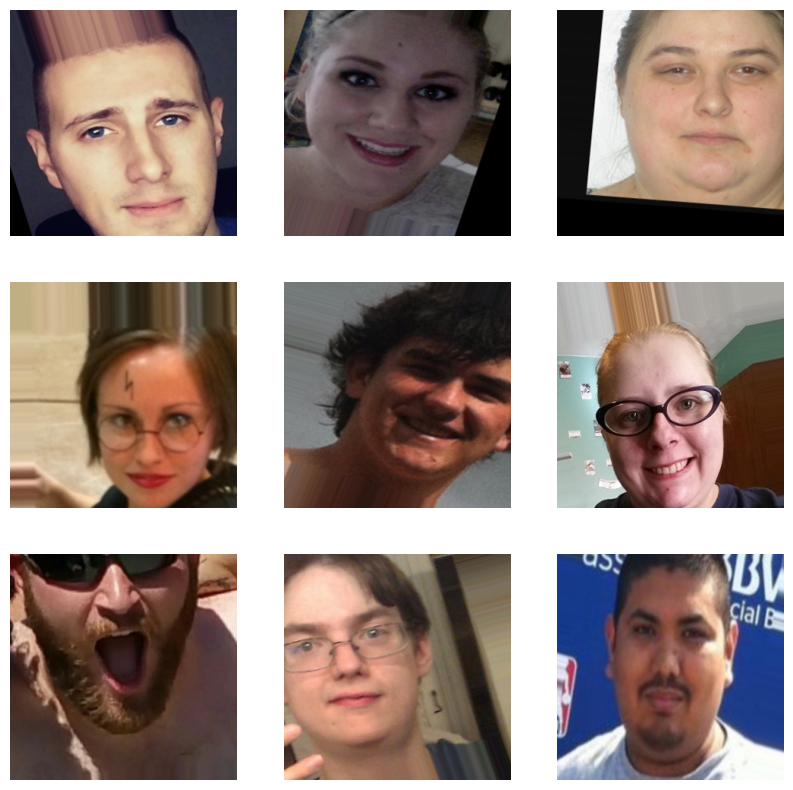

In [44]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming x_train is your image data and datagen is your ImageDataGenerator
# Get a batch of augmented images
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Display the augmented images
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i in range(9):
        row = i // 3
        col = i % 3
        print(x_batch[i])
        # Clip pixel values to 0-1 range and then display
        axes[row, col].imshow(np.clip(x_batch[i], 0, 1))  # Clip pixel values before displaying
        axes[row, col].axis('off')
    plt.show()
    break # Only show one batch of images

In [45]:
import gc
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D # Import Flatten and Dense
from tensorflow.keras.applications import InceptionV3
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_mae',  # Metric to monitor for early stopping (validation MAE in this case)
    patience=5,        # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity.
)

# Define the model checkpoint callback to save the best model weights
model_checkpoint = ModelCheckpoint(
    filepath='best_model_weights.keras',  # Path to save the best model weights
    monitor='val_mae',  # Metric to monitor for saving the best model
    save_best_only=True,  # Only save the model when the monitored quantity improves
    verbose=1             # Verbosity mode, 0 = silent, 1 = progress bar, 2 = one line per epoch
)


def InceptionV3_training(dropout=None, dense=None, total_epochs=50):
    # 1. Load the pre-trained VGG16 model (with ImageNet weights)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

    # 2. Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # 3. Add new classification layers on top
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    if dropout:
        x = Dropout(dropout)(x)
    if dense:
        x = Dense(dense)(x)
    predictions = Dense(units=1, activation='linear')(x)  # num_classes is the number of classes in your dataset

    # 4. Create the fine-tuned model
    model = Model(inputs=base_model.input, outputs=predictions)

    # 5. Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a low learning rate for fine-tuning
                loss='mean_squared_error',  # Or other appropriate loss function
                metrics=['mae'])

   # for layer in model.layers:
   #     print(layer, layer.trainable)
   # model.summary()

    batch_size = 64

    # Train the model for one epoch
    model.fit(
        datagen.flow(x_train, y_train, batch_size=batch_size),  # augmentation
        epochs=total_epochs,
        validation_data=(x_val, y_val),
        verbose=1,
        callbacks=[early_stopping, model_checkpoint]
    )

    # Evaluate the model on validation data
    val_loss, val_mae = model.evaluate(x_val, y_val, verbose=0)
    print(f"Validation MAE: {val_mae:.4f}")


    # free memory
    gc.collect()
    del model

    # Load the best weights into the model
    model.load_weights('best_model_weights.keras')

    # 8. Make predictions on test data
    predictions = model.predict(x_test)
    # Calculate MAE
    mae = mean_absolute_error(y_test, predictions.flatten())
    # Print MAE
    print(f"dropout={dropout}, dense={dense}, Mean Absolute Error (MAE): {mae:.2f}")




In [46]:
print("InceptionV3 test results")

InceptionV3_training(dropout=0.25)



InceptionV3 test results
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - loss: 1139.0969 - mae: 32.7628
Epoch 1: val_mae improved from inf to 32.58302, saving model to best_model_weights.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 1137.0037 - mae: 32.7262 - val_loss: 1150.0441 - val_mae: 32.5830
Epoch 2/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 853ms/step - loss: 998.2369 - mae: 30.4734
Epoch 2: val_mae improved from 32.58302 to 30.64584, saving model to best_model_weights.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 887ms/step - loss: 996.9799 - mae: 30.4521 - val_loss: 1027.8551 - val_mae: 30.6458
Epoch 3/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 889ms/step - loss: 873.1027 - mae: 28.3926
Epoch 3: val_mae improved from 30.64584 to 28.78556, saving model to best_model_weights.keras
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 904ms/step - loss: 872.2377 - mae: 28.3733 - val_loss: 917.7543 - val_mae: 28.7856
Epoch 4/50
32/33 ━━━━━━━━━━━━━━━━━━━━ 0s 856ms/step - loss: 786.2463 - mae: 26.7522
Epoch 4: val_mae improved from 28.78556 to 26.97178, sa

KeyboardInterrupt: 

In [ ]:
InceptionV3_training(dropout=0.25, dense=128)
InceptionV3_training(dropout=0.25, dense=1024)
InceptionV3_training(dropout=0.5, dense=1024)

# Test

In [ ]:
import random
import matplotlib.pyplot as plt # Import matplotlib.pyplot
# 7. Load test set images and labels

test_images = x_test
test_texts = y_test

# 8. Make predictions on test data
predictions = model.predict(test_images)

# 9. Visualize predictions and ground truth
num_samples_to_display = 30  # Number of samples to visualize
random_indices = random.sample(range(len(test_images)), num_samples_to_display)

for i in random_indices:
    filename_without_extension = os.path.basename(test_filenames[i]).split(".")[0]
    index = np.where(test_filenames == filename_without_extension + ".bmp")[0][0]

    image = test_images[i]
    predicted_text = predictions[i][0]  # Assuming single output for regression
    ground_truth_text = test_texts[index]
    filename = test_filenames[index]  # Get the filename

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_text:.2f} \n Filename: {filename}")  # Format for regression output

    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5, ground_truth_text, ha='center', va='center', fontsize=12)
    plt.title("Ground Truth")
    plt.axis('off')

    plt.show()

Output hidden; open in https://colab.research.google.com to view.